<a href="https://colab.research.google.com/github/1kaiser/test2022/blob/main/MODIS_MOD10A1_Snow_Cover_Area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **RUNNING CODE NDSI *MOD10A1.061* DAILY**  
## 🌨️❄️🏔️  **SNOW COVER AREA**  🏔️❄️🌨️

### pre requisites please run this section >>>>

In [ ]:
!python -m pip install pyModis
!sudo apt-get install jq

!gdown https://drive.google.com/uc?id=1oyqXeHZgaTOjLod-Vqz-VAzS88O13JDr
!unzip /content/beasBasinShapeFile.zip -d /content


### Process Data Here

In [ ]:
#@title PROCESSING IMAGES FOR SNOW COVER >>> SAVING  *.TXT FILE { vertical-output: true }
import os
import pymodis
import gdalnumeric
#to clear output
from google.colab import output


image_dir = r'/content/drive/MyDrive/OUT/data/MOD10A1v6daily/'
fileExt = r'.hdf'
temp_dir = r'/content/'
imgs_list = [f for f in os.listdir(image_dir) if f.endswith(fileExt)]
imgs_list.sort()
imgs_path = [os.path.join(image_dir, i) for i in imgs_list if i != 'outputs']
#creating a loop to run for all files in the directory having extension ".hdf"
for name, image in enumerate(imgs_path):
  print('ok')
  print(name)
  print(image)
  path = imgs_list[name]
  #converting to sinusodial coordinate system to wgs 84 utm 43
  #import pymodis
  subset = [0,0,0,1,0,0,0]
  pymodis.convertmodis_gdal.convertModisGDAL( image_dir + path, temp_dir + path[:-4], subset, 2400,outformat="GTiff",epsg=32643).run()
  
  #cutting into Area Of interest using shape file
  !gdalwarp \
  -ot Float32 \
  -cutline /content/beasBasinShapeFile.shp  -crop_to_cutline \
  {temp_dir}{path[:-4]}"_ndsi.tif" \
  {temp_dir}{path[:-4]}"_ndsi_clipped.tif"

  !rm -r {temp_dir}{path[:-4]}"_ndsi.tif"
  #deleting file

  #creating file NDSI>=0.4
  !gdal_calc.py \
  --overwrite \
  --type=Float32 \
  -A {temp_dir}{path[:-4]}"_ndsi_clipped.tif" \
  --A_band 1 \
  --outfile={temp_dir}{path[:-4]}"_result.tif" \
  --calc="A.astype(float)>=400"

  !rm -r {temp_dir}{path[:-4]}"_ndsi_clipped.tif"
  #deleting file

  #counting Snow and Non-Snowpixels  
  #import gdalnumeric
  raster_file = gdalnumeric.LoadFile(temp_dir + path[:-4]+"_result.tif")
  pixel_count_snow = (raster_file ==0).sum()
  pixel_count_notsnow = (raster_file ==1).sum()
  print("snow:",pixel_count_snow," not snow:",pixel_count_notsnow)

  #creating constant for multiplication at pixel size with count of pixels
  m1 = !gdalinfo -json {temp_dir}{path[:-4]}"_result.tif" | jq -r .geoTransform 
  coonstant_c = int(m1[2][9:9+4])*int(m1[6][9+1:9+4+1])/1000000

  !rm -r {temp_dir}{path[:-4]}"_result.tif"
  #deleting file

  #combining name of the  file , SnowCoverArea , NonSnowCoverArea to a text file format
  lines = str(path[8:8+8] + "," + str(coonstant_c*pixel_count_snow) + "," + str(coonstant_c*pixel_count_notsnow))
  with open(temp_dir+"out.txt","a+", encoding="utf-8") as f:
    f.writelines('\n'+ lines)
    output.clear() #to_clear_the_output_console_everytime

## DOWNLOADING MOD10A.061 daily

SET FILE LOCATIONS AND CREATIONS

In [ ]:
!mkdir -p /content/drive/MyDrive/OUT/data/MOD10A1v6daily
!ls /content/drive/MyDrive/OUT/
%cd /content/drive/MyDrive/OUT/data/MOD10A1v6daily

In [ ]:
%cd /content/drive/MyDrive/OUT/data/MOD10A1v6daily

just change >>>
```
time_start = '2018-03-01T00:00:00Z'
time_end = '2022-08-05T17:40:42Z'
bounding_box = '75.65,31,78.69,32.74'
```
as per requirement IF download gets interrupted then check in google drive the
```
MOD10A1.A2018108.h24v05.061.2021324032344.hdf
```
> `A2018108`  is "2018" year and "108" th day of the year i.e. "2018-04-18" << that means it have successfully downloaded tillthen now change 
>`time_start` to `2018-04-18T00:00:00Z `
>`time_end` to `2022-08-05T17:40:42Z`
>>even the bounding box is updatable to user required co-ordinates

In [ ]:
#@title DOWNLOADING MOD10A1.061 DAILY DATA >>> { vertical-output: true }

from __future__ import print_function

import base64
import getopt
import itertools
import json
import math
import netrc
import os.path
import ssl
import sys
import time
from getpass import getpass

try:
    from urllib.parse import urlparse
    from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
    from urllib.error import HTTPError, URLError
except ImportError:
    from urlparse import urlparse
    from urllib2 import urlopen, Request, HTTPError, URLError, build_opener, HTTPCookieProcessor

short_name = 'MOD10A1'
version = '61'
time_start = '2015-05-26T00:00:00Z'
time_end = '2022-08-05T17:40:42Z'
bounding_box = '75.65,31,78.69,32.74'
polygon = ''
filename_filter = ''
url_list = []

CMR_URL = 'https://cmr.earthdata.nasa.gov'
URS_URL = 'https://urs.earthdata.nasa.gov'
CMR_PAGE_SIZE = 2000
CMR_FILE_URL = ('{0}/search/granules.json?provider=NSIDC_ECS'
                '&sort_key[]=start_date&sort_key[]=producer_granule_id'
                '&scroll=true&page_size={1}'.format(CMR_URL, CMR_PAGE_SIZE))


def get_username():
    username = 'kroy0001'
    while not username:
      # For Python 2/3 compatibility:
      try:
          do_input = raw_input  # noqa
      except NameError:
          do_input = input
      username = do_input('Earthdata username (or press Return to use a bearer token): ')
    return username


def get_password():
    password = '/#j%kWrPA,8.HRe'
    while not password:
        password = getpass('password: ')
    return password

def get_token():
    token = ''
    while not token:
        token = getpass('bearer token: ')
    return token


def get_login_credentials():
    """Get user credentials from .netrc or prompt for input."""
    credentials = None
    token = None

    try:
        info = netrc.netrc()
        username, account, password = info.authenticators(urlparse(URS_URL).hostname)
        if username == 'token':
            token = password
        else:
            credentials = '{0}:{1}'.format(username, password)
            credentials = base64.b64encode(credentials.encode('ascii')).decode('ascii')
    except Exception:
        username = None
        password = None

    if not username:
        username = get_username()
        if len(username):
            password = get_password()
            credentials = '{0}:{1}'.format(username, password)
            credentials = base64.b64encode(credentials.encode('ascii')).decode('ascii')
        else:
            token = get_token()

    return credentials, token


def build_version_query_params(version):
    desired_pad_length = 3
    if len(version) > desired_pad_length:
        print('Version string too long: "{0}"'.format(version))
        quit()

    version = str(int(version))  # Strip off any leading zeros
    query_params = ''

    while len(version) <= desired_pad_length:
        padded_version = version.zfill(desired_pad_length)
        query_params += '&version={0}'.format(padded_version)
        desired_pad_length -= 1
    return query_params


def filter_add_wildcards(filter):
    if not filter.startswith('*'):
        filter = '*' + filter
    if not filter.endswith('*'):
        filter = filter + '*'
    return filter


def build_filename_filter(filename_filter):
    filters = filename_filter.split(',')
    result = '&options[producer_granule_id][pattern]=true'
    for filter in filters:
        result += '&producer_granule_id[]=' + filter_add_wildcards(filter)
    return result


def build_cmr_query_url(short_name, version, time_start, time_end,
                        bounding_box=None, polygon=None,
                        filename_filter=None):
    params = '&short_name={0}'.format(short_name)
    params += build_version_query_params(version)
    params += '&temporal[]={0},{1}'.format(time_start, time_end)
    if polygon:
        params += '&polygon={0}'.format(polygon)
    elif bounding_box:
        params += '&bounding_box={0}'.format(bounding_box)
    if filename_filter:
        params += build_filename_filter(filename_filter)
    return CMR_FILE_URL + params


def get_speed(time_elapsed, chunk_size):
    if time_elapsed <= 0:
        return ''
    speed = chunk_size / time_elapsed
    if speed <= 0:
        speed = 1
    size_name = ('', 'k', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y')
    i = int(math.floor(math.log(speed, 1000)))
    p = math.pow(1000, i)
    return '{0:.1f}{1}B/s'.format(speed / p, size_name[i])


def output_progress(count, total, status='', bar_len=60):
    if total <= 0:
        return
    fraction = min(max(count / float(total), 0), 1)
    filled_len = int(round(bar_len * fraction))
    percents = int(round(100.0 * fraction))
    bar = '=' * filled_len + ' ' * (bar_len - filled_len)
    fmt = '  [{0}] {1:3d}%  {2}   '.format(bar, percents, status)
    print('\b' * (len(fmt) + 4), end='')  # clears the line
    sys.stdout.write(fmt)
    sys.stdout.flush()


def cmr_read_in_chunks(file_object, chunk_size=1024 * 1024):
    """Read a file in chunks using a generator. Default chunk size: 1Mb."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data


def get_login_response(url, credentials, token):
    opener = build_opener(HTTPCookieProcessor())

    req = Request(url)
    if token:
        req.add_header('Authorization', 'Bearer {0}'.format(token))
    elif credentials:
        try:
            response = opener.open(req)
            # We have a redirect URL - try again with authorization.
            url = response.url
        except HTTPError:
            # No redirect - just try again with authorization.
            pass
        except Exception as e:
            print('Error{0}: {1}'.format(type(e), str(e)))
            sys.exit(1)

        req = Request(url)
        req.add_header('Authorization', 'Basic {0}'.format(credentials))

    try:
        response = opener.open(req)
    except HTTPError as e:
        err = 'HTTP error {0}, {1}'.format(e.code, e.reason)
        if 'Unauthorized' in e.reason:
            if token:
                err += ': Check your bearer token'
            else:
                err += ': Check your username and password'
        print(err)
        sys.exit(1)
    except Exception as e:
        print('Error{0}: {1}'.format(type(e), str(e)))
        sys.exit(1)

    return response


def cmr_download(urls, force=False, quiet=False):
    """Download files from list of urls."""
    if not urls:
        return

    url_count = len(urls)
    if not quiet:
        print('Downloading {0} files...'.format(url_count))
    credentials = None
    token = None

    for index, url in enumerate(urls, start=1):
        if not credentials and not token:
            p = urlparse(url)
            if p.scheme == 'https':
                credentials, token = get_login_credentials()

        filename = url.split('/')[-1]
        if not quiet:
            print('{0}/{1}: {2}'.format(str(index).zfill(len(str(url_count))),
                                        url_count, filename))

        try:
            response = get_login_response(url, credentials, token)
            length = int(response.headers['content-length'])
            try:
                if not force and length == os.path.getsize(filename):
                    if not quiet:
                        print('  File exists, skipping')
                    continue
            except OSError:
                pass
            count = 0
            chunk_size = min(max(length, 1), 1024 * 1024)
            max_chunks = int(math.ceil(length / chunk_size))
            time_initial = time.time()
            with open(filename, 'wb') as out_file:
                for data in cmr_read_in_chunks(response, chunk_size=chunk_size):
                    out_file.write(data)
                    if not quiet:
                        count = count + 1
                        time_elapsed = time.time() - time_initial
                        download_speed = get_speed(time_elapsed, count * chunk_size)
                        output_progress(count, max_chunks, status=download_speed)
            if not quiet:
                print()
        except HTTPError as e:
            print('HTTP error {0}, {1}'.format(e.code, e.reason))
        except URLError as e:
            print('URL error: {0}'.format(e.reason))
        except IOError:
            raise


def cmr_filter_urls(search_results):
    """Select only the desired data files from CMR response."""
    if 'feed' not in search_results or 'entry' not in search_results['feed']:
        return []

    entries = [e['links']
               for e in search_results['feed']['entry']
               if 'links' in e]
    # Flatten "entries" to a simple list of links
    links = list(itertools.chain(*entries))

    urls = []
    unique_filenames = set()
    for link in links:
        if 'href' not in link:
            # Exclude links with nothing to download
            continue
        if 'inherited' in link and link['inherited'] is True:
            # Why are we excluding these links?
            continue
        if 'rel' in link and 'data#' not in link['rel']:
            # Exclude links which are not classified by CMR as "data" or "metadata"
            continue

        if 'title' in link and 'opendap' in link['title'].lower():
            # Exclude OPeNDAP links--they are responsible for many duplicates
            # This is a hack; when the metadata is updated to properly identify
            # non-datapool links, we should be able to do this in a non-hack way
            continue

        filename = link['href'].split('/')[-1]
        if filename in unique_filenames:
            # Exclude links with duplicate filenames (they would overwrite)
            continue
        unique_filenames.add(filename)

        urls.append(link['href'])

    return urls


def cmr_search(short_name, version, time_start, time_end,
               bounding_box='', polygon='', filename_filter='', quiet=False):
    """Perform a scrolling CMR query for files matching input criteria."""
    cmr_query_url = build_cmr_query_url(short_name=short_name, version=version,
                                        time_start=time_start, time_end=time_end,
                                        bounding_box=bounding_box,
                                        polygon=polygon, filename_filter=filename_filter)
    if not quiet:
        print('Querying for data:\n\t{0}\n'.format(cmr_query_url))

    cmr_scroll_id = None
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    urls = []
    hits = 0
    while True:
        req = Request(cmr_query_url)
        if cmr_scroll_id:
            req.add_header('cmr-scroll-id', cmr_scroll_id)
        try:
            response = urlopen(req, context=ctx)
        except Exception as e:
            print('Error: ' + str(e))
            sys.exit(1)
        if not cmr_scroll_id:
            # Python 2 and 3 have different case for the http headers
            headers = {k.lower(): v for k, v in dict(response.info()).items()}
            cmr_scroll_id = headers['cmr-scroll-id']
            hits = int(headers['cmr-hits'])
            if not quiet:
                if hits > 0:
                    print('Found {0} matches.'.format(hits))
                else:
                    print('Found no matches.')
        search_page = response.read()
        search_page = json.loads(search_page.decode('utf-8'))
        url_scroll_results = cmr_filter_urls(search_page)
        if not url_scroll_results:
            break
        if not quiet and hits > CMR_PAGE_SIZE:
            print('.', end='')
            sys.stdout.flush()
        urls += url_scroll_results

    if not quiet and hits > CMR_PAGE_SIZE:
        print()
    return urls


def main(argv=None):
    global short_name, version, time_start, time_end, bounding_box, \
        polygon, filename_filter, url_list

    if argv is None:
        argv = sys.argv[1:]

    force = False
    quiet = False
    usage = 'usage: nsidc-download_***.py [--help, -h] [--force, -f] [--quiet, -q]'

    try:
        opts, args = getopt.getopt(argv, 'hfq', ['help', 'force', 'quiet'])
        for opt, _arg in opts:
            if opt in ('-f', '--force'):
                force = True
            elif opt in ('-q', '--quiet'):
                quiet = True
            elif opt in ('-h', '--help'):
                print(usage)
                sys.exit(0)
    except getopt.GetoptError as e:
        print(e.args[0])
        print(usage)
        sys.exit(1)

    # Supply some default search parameters, just for testing purposes.
    # These are only used if the parameters aren't filled in up above.
    if 'short_name' in short_name:
        short_name = 'ATL06'
        version = '003'
        time_start = '2018-10-14T00:00:00Z'
        time_end = '2021-01-08T21:48:13Z'
        bounding_box = ''
        polygon = ''
        filename_filter = '*ATL06_2020111121*'
        url_list = []

    try:
        if not url_list:
            url_list = cmr_search(short_name, version, time_start, time_end,
                                  bounding_box=bounding_box, polygon=polygon,
                                  filename_filter=filename_filter, quiet=quiet)

        cmr_download(url_list, force=force, quiet=quiet)
    except KeyboardInterrupt:
        quit()


if __name__ == '__main__':
    main()


# testing slope map

In [ ]:
%cd /content
!mkdir -p /content/dem /content/out_dem /content/out_aspect_dem

/content


In [ ]:
%cd /content/dem
!gdown https://drive.google.com/uc?id=1-8x01glg16zLwy3NO08oukZMs4Ms2lgP
%cd /content/

/content/dem
Downloading...
From: https://drive.google.com/uc?id=1-8x01glg16zLwy3NO08oukZMs4Ms2lgP
To: /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif
100% 32.2M/32.2M [00:00<00:00, 109MB/s]
/content


In [ ]:
!rm -r /content/out_aspect_dem /content/out_dem

In [ ]:
#✅Slope_calculations
import os
image_dir = r'/content/dem/'
fileExt = r'.tif'
temp_dir = r'/content/out_dem/'
imgs_list = [f for f in os.listdir(image_dir) if f.endswith(fileExt)]
imgs_list.sort()
imgs_path = [os.path.join(image_dir, i) for i in imgs_list if i != 'outputs']
for i, name in enumerate(imgs_path):
  path = imgs_list[i]
  !gdaldem slope {image_dir}{path} {temp_dir}{path[:-4]}"_slope.tif" -compute_edges -of GTiff -b 1 -p 

In [ ]:
#✅aspect_calculations
import os
image_dir = r'/content/dem/'
fileExt = r'.tif'
temp_dir = r'/content/out_aspect_dem/'
imgs_list = [f for f in os.listdir(image_dir) if f.endswith(fileExt)]
imgs_list.sort()
imgs_path = [os.path.join(image_dir, i) for i in imgs_list if i != 'outputs']
for i, name in enumerate(imgs_path):
  path = imgs_list[i]
  !gdaldem aspect {image_dir}{path} {temp_dir}{path[:-4]}"_aspect.tif" -compute_edges -of GTiff -b 1

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

#os.system (cmd)
slp1=gdal.Open("/content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

In [ ]:
!gdalinfo /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_slope_aspect.tif

In [ ]:
!gdal_calc.py \
  --overwrite \
  --type=Float32 \
  -A "/content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif" \
  --A_band 1 \
  --outfile="/content/check.tif" \
  --calc="(A.astype(float)>=1000)*(A.astype(float)<=3000)"

import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

#os.system (cmd)
slp1=gdal.Open("/content/check.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

100
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
3000
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
5000
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
100
/content/elevations/result_100.tif


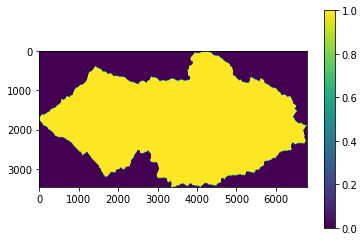

3000
/content/elevations/result_3000.tif


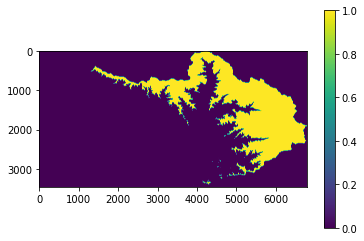

5000
/content/elevations/result_5000.tif


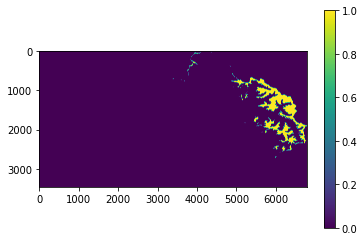

In [ ]:
#✅Separate_by_elevations
elev = [100, 3000, 5000]
temp_dir = "/content/elevations/"
!mkdir -p {temp_dir}
for i, elevations in enumerate(elev):
  print(elev[i])
  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif --outfile={temp_dir}result_"{elev[i]}".tif --calc="A>={elev[i]}" --NoDataValue=0



# !gdal_calc.py \
#   --overwrite \
#   --type=Float32 \
#   -A /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif --outfile=result_1000.tif --calc="A>=1000" --NoDataValue=0

import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt


for i, elevations in enumerate(elev):
  print(elev[i])
  print(temp_dir+"result_"+str(elev[i])+".tif")
  #os.system (cmd)
  slp1=gdal.Open(temp_dir+"result_"+str(elev[i])+".tif")
  slp1Array= slp1.GetRasterBand(1).ReadAsArray()
  plt.figure()
  plt.imshow(slp1Array)
  plt.colorbar()
  plt.show()

In [ ]:
#✅Polygonoze_each_extracted_elevation_raster_as_shape_file
!mkdir -p "/content/polygon_shp/"
for i, elevations in enumerate(elev):
  print(elev[i])
  dir_to_store = "/content/polygon_shp/"+str(elev[i])+"_shpFile/"
  !mkdir -p {dir_to_store}
  !gdal_polygonize.py {temp_dir}result_{elev[i]}.tif -f "ESRI Shapefile" {dir_to_store}result_{elev[i]}.shp OUTPUT DN  #✅

100
Creating output /content/polygon_shp/100_shpFile/result_100.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
3000
Creating output /content/polygon_shp/3000_shpFile/result_3000.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
5000
Creating output /content/polygon_shp/5000_shpFile/result_5000.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!rm -r /content/elevations_aspects

In [ ]:
!gdown https://drive.google.com/uc?id=1pQH1VU_KX1TIbJLHvptxAFup10EUj6nX

In [ ]:
!unzip /content/correct.zip

In [ ]:
#✅Separate_by_elevations_THEN_aspects
elev = [ 1001000, 10002000, 20003000, 30004000, 40005000, 50006000, 60007000]

aspects = [0, 45, 90, 135, 180, 225, 270, 315]
temp_dir = "/content/elevations_aspects/"
!mkdir -p {temp_dir}
temp_dir_elevations = "/content/correct/"
for j, elevations in enumerate(elev):
  !gdalwarp \
    -ot Float32 \
    -cutline {temp_dir_elevations}E{elev[j]}.shp  -crop_to_cutline \
    /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif \
    {temp_dir}result_"{elev[j]}".tif


In [ ]:
#✅Separate_by_elevations_aspects
elev = [ 1001000, 10002000, 20003000, 30004000, 40005000, 50006000, 60007000]

aspects = [0, 45, 90, 135, 180, 225, 270, 315]
temp_dir = "/content/elevations_aspects/"
!mkdir -p {temp_dir}
temp_dir_elevations = "/content/correct/"
for j, elevations in enumerate(elev):
  !gdalwarp \
    -ot Float32 \
    -cutline {temp_dir_elevations}E{elev[j]}.shp  -crop_to_cutline \
    /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif \
    {temp_dir}result_"{elev[j]}".tif

for j, elevations in enumerate(elev):
  !mkdir -p {temp_dir}"A"{elev[j]}
  for i, aspect in enumerate(aspects):
      print(aspects[i])
      !gdal_calc.py \
        --overwrite \
        --type=Float32 \
        -A {temp_dir}result_"{elev[j]}".tif --outfile={temp_dir}"A"{elev[j]}"/"result_"{aspects[i]}".tif --calc="A>={aspects[i]}" --NoDataValue=0

# !gdal_calc.py \
#   --overwrite \
#   --type=Float32 \
#   -A /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif --outfile=result_1000.tif --calc="A>=1000" --NoDataValue=0

import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

for j, elevations in enumerate(elev):
  for i, aspect in enumerate(aspects):
    print(aspects[i])
    print(temp_dir+"A"+str(elev[j])+"/result_"+str(aspects[i])+".tif")
    #os.system (cmd)
    slp1=gdal.Open(temp_dir+"A"+str(elev[j])+"/result_"+str(aspects[i])+".tif")
    slp1Array= slp1.GetRasterBand(1).ReadAsArray()
    plt.figure()
    plt.imshow(slp1Array)
    plt.colorbar()
    plt.show()

In [ ]:
#✅Polygonoze_each_extracted_elevation&aspects[8]_raster_as_shape_file

elev = [ 1001000, 10002000, 20003000, 30004000, 40005000, 50006000, 60007000]
aspects = [0, 45, 90, 135, 180, 225, 270, 315]
temp_dir = "/content/elevations_aspects/"
!mkdir -p "/content/polygon_shp/"
for j, elevations in enumerate(elev):
  for i, aspect in enumerate(aspects):
    print(elev[j])
    dir_to_store = "/content/polygon_shp/A"+str(elev[j])+"_shpFile/"
    !mkdir -p {dir_to_store}
    !gdal_polygonize.py {temp_dir}A{elev[j]}/result_{aspects[i]}.tif -f "ESRI Shapefile" {dir_to_store}result_{aspects[i]}.shp OUTPUT DN  #✅

In [ ]:
!rm -r /content/polygon_shp

### TEST 2 FOR ASPECTS POLYGONIZATION >>> AS EACH ELEVATION IS CUT INTO [8] ASPECTS

In [ ]:
!gdown https://drive.google.com/uc?id=1lU78Fte5QAJevfmwFLhCFBIoc8xLzLoK

Downloading...
From: https://drive.google.com/uc?id=1lU78Fte5QAJevfmwFLhCFBIoc8xLzLoK
To: /content/elev_correct.zip
100% 480k/480k [00:00<00:00, 95.6MB/s]


In [ ]:
!unzip /content/elev_correct.zip

Archive:  /content/elev_correct.zip
 extracting: elev_correct/E1003000.cpg  
  inflating: elev_correct/E1003000.dbf  
  inflating: elev_correct/E1003000.prj  
  inflating: elev_correct/E1003000.qmd  
  inflating: elev_correct/E1003000.shp  
  inflating: elev_correct/E1003000.shx  
 extracting: elev_correct/E30005000.cpg  
  inflating: elev_correct/E30005000.dbf  
  inflating: elev_correct/E30005000.prj  
  inflating: elev_correct/E30005000.qmd  
  inflating: elev_correct/E30005000.shp  
  inflating: elev_correct/E30005000.shx  
 extracting: elev_correct/E50007000.cpg  
  inflating: elev_correct/E50007000.dbf  
  inflating: elev_correct/E50007000.prj  
  inflating: elev_correct/E50007000.qmd  
  inflating: elev_correct/E50007000.shp  
  inflating: elev_correct/E50007000.shx  


In [ ]:
#✅Separate_by_elevations_THEN_aspects
elev = [1003000, 30005000, 50007000]

aspects = [0, 45, 90, 135, 180, 225, 270, 315]
temp_dir = "/content/elevations_aspects/"
!mkdir -p {temp_dir}
temp_dir_elevations = "/content/elev_correct/"
for j, elevations in enumerate(elev):
  !gdalwarp \
    -ot Float32 \
    -cutline {temp_dir_elevations}E{elev[j]}.shp  -crop_to_cutline \
    /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif \
    {temp_dir}result_"{elev[j]}".tif


Creating output file that is 5840P x 3283L.
Processing input file /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif.
Using internal nodata values (e.g. -9999) for image /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif.
Copying nodata values from source /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif to destination /content/elevations_aspects/result_1003000.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5421P x 3422L.
Processing input file /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif.
Using internal nodata values (e.g. -9999) for image /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif.
Copying nodata values from source /content/out_aspect_dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001_aspect.tif to destination /content/elevations_aspects/result_30005000.tif.
0...10...20...30..

In [ ]:
!rm -r /content/polygon_shp

In [ ]:
#✅Separate_by_aspect_each_elevations_THEN_polygonize_each_vectors
formulas = ["(A<=45)*1", "(A>46)*(A<=90)*2", "(A>90)*(A<=135)*3", "(A>136)*(A<=180)*4", "(A>181)*(A<=225)*5", "(A>226)*(A<=270)*6", "(A>271)*(A<=315)*7", "(A>316)*8"]
print(len(formulas))
CLIPPED_ELEVATIONS = "/content/elevations_aspects/"
elev = [1003000, 30005000, 50007000]
aspects = [0, 45, 90, 135, 180, 225, 270, 315]
temp_dir = "/content/elevations_aspects/"
!mkdir -p "/content/polygon_shp/"
for j, elevations in enumerate(elev):
  in_image = str(CLIPPED_ELEVATIONS)+"result_"+str(elev[j])+".tif"
  print(in_image)
  dir_to_store = "/content/polygon_shp/A"+str(elev[j])+"_shpFile/"
  !mkdir -p {dir_to_store}

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB1.tif \
    --NoDataValue=0 \
    --calc="(A<=45)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB1.tif -f "ESRI Shapefile" {dir_to_store}result_B1.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB2.tif \
    --NoDataValue=0 \
    --calc="(A>46)*(A<=90)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB2.tif -f "ESRI Shapefile" {dir_to_store}result_B2.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB3.tif \
    --NoDataValue=0 \
    --calc="(A>90)*(A<=135)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB3.tif -f "ESRI Shapefile" {dir_to_store}result_B3.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB4.tif \
    --NoDataValue=0 \
    --calc="(A>136)*(A<=180)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB4.tif -f "ESRI Shapefile" {dir_to_store}result_B4.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB5.tif \
    --NoDataValue=0 \
    --calc="(A>181)*(A<=225)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB5.tif -f "ESRI Shapefile" {dir_to_store}result_B5.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB6.tif \
    --NoDataValue=0 \
    --calc="(A>226)*(A<=270)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB6.tif -f "ESRI Shapefile" {dir_to_store}result_B6.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB7.tif \
    --NoDataValue=0 \
    --calc="(A>271)*(A<=315)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB7.tif -f "ESRI Shapefile" {dir_to_store}result_B7.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB8.tif \
    --NoDataValue=0 \
    --calc="(A>316)*8"
  !gdal_polygonize.py {dir_to_store}SmallerFileB8.tif -f "ESRI Shapefile" {dir_to_store}result_B8.shp OUTPUT DN  #✅


# import os
# import subprocess
# from osgeo import gdal
# import matplotlib.pyplot as plt

# for i, formula in enumerate(formulas):
#   #os.system (cmd)
#   slp1=gdal.Open("/content/SmallerFileB"+str(i+1)+".tif")
#   slp1Array= slp1.GetRasterBand(1).ReadAsArray()
#   plt.figure()
#   plt.imshow(slp1Array)
#   plt.colorbar()
#   plt.show()

8
/content/elevations_aspects/result_1003000.tif
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/polygon_shp/A1003000_shpFile/result_B1.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/polygon_shp/A1003000_shpFile/result_B2.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/polygon_shp/A1003000_shpFile/result_B3.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/polygon_shp/A1003000_shpFile/result_B4.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .

download the polygon shape files for aspects[8] for each elevations use "FIX GEOMETRY" using qgis then re ipload for computations

In [ ]:
%cd /content/polygon_shp
!zip -r /content/poly_shp_filesX.zip /content/polygon_shp/*
%cd /content/

/content/polygon_shp
  adding: content/polygon_shp/A1003000_shpFile/ (stored 0%)
  adding: content/polygon_shp/A1003000_shpFile/result_B7.dbf (deflated 100%)
  adding: content/polygon_shp/A1003000_shpFile/result_B6.prj (deflated 15%)
  adding: content/polygon_shp/A1003000_shpFile/result_B4.shp (deflated 79%)
  adding: content/polygon_shp/A1003000_shpFile/SmallerFileB1.tif (deflated 99%)
  adding: content/polygon_shp/A1003000_shpFile/result_B2.dbf (deflated 100%)
  adding: content/polygon_shp/A1003000_shpFile/result_B1.shx (deflated 55%)
  adding: content/polygon_shp/A1003000_shpFile/result_B3.prj (deflated 15%)
  adding: content/polygon_shp/A1003000_shpFile/result_B7.prj (deflated 15%)
  adding: content/polygon_shp/A1003000_shpFile/result_B2.shp (deflated 80%)
  adding: content/polygon_shp/A1003000_shpFile/result_B5.shx (deflated 56%)
  adding: content/polygon_shp/A1003000_shpFile/SmallerFileB5.tif (deflated 99%)
  adding: content/polygon_shp/A1003000_shpFile/SmallerFileB2.tif (deflate

### TESTING DEM CUT BY RASTER CALCULATION USING `gdal_calc`

In [ ]:
import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

#os.system (cmd)
slp1=gdal.Open("/content/SmallerFileB.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

In [ ]:
#cutting into Area Of interest using shape file
!gdalwarp \
  -ot Float32 \
  -cutline /content/correct/E0400_1000.shp \
  /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif \
  /content/clipped.tif

In [ ]:
!ogr2ogr filtered_result.shp /content/result_1000.shp -where "DN=1"


In [ ]:
# !gdal_calc.py \
#   --overwrite \
#   --type=Float32 \
#   -A /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif --outfile=result_1000.tif --calc="A>=100" --NoDataValue=0
# !gdal_polygonize.py result_1000.tif  -f "ESRI Shapefile" /content/xyz.shp OUTPUT DN  #✅

clipping by raster to raster

In [ ]:

import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt

#os.system (cmd)
slp1=gdal.Open("/content/clipped.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

In [ ]:
import os
import subprocess
from osgeo import gdal
import matplotlib.pyplot as plt
!gdal_calc.py \
  --overwrite \
  --type=Float32 \
  -A /content/result_4000.tif -B /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif --outfile=SmallerFileA.tif --NoDataValue=0 --calc="B.astype(float)*(A>=0)" 


#os.system (cmd)
slp1=gdal.Open("/content/SmallerFileA.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

!gdal_calc.py \
  --overwrite \
  --type=Float32 \
  -A /content/result_2000.tif -B /content/dem/SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif --outfile=SmallerFileB.tif --NoDataValue=0 --calc="B.astype(float)*(A>=0)" 


#os.system (cmd)
slp1=gdal.Open("/content/SmallerFileB.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

!gdal_calc.py \
  --overwrite \
  --type=Float32 \
  -A /content/SmallerFileA.tif -B /content/SmallerFileB.tif --outfile=SmallerFileC.tif --NoDataValue=0 --calc="(B-A)" 


#os.system (cmd)
slp1=gdal.Open("/content/SmallerFileC.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

In [ ]:
%cd /content/polygon_shp
!zip -r /content/poly_shp_files.zip /content/polygon_shp/*
%cd /content/

/content/polygon_shp
  adding: content/polygon_shp/100_shpFile/ (stored 0%)
  adding: content/polygon_shp/100_shpFile/result_100.shx (deflated 46%)
  adding: content/polygon_shp/100_shpFile/result_100.prj (deflated 15%)
  adding: content/polygon_shp/100_shpFile/result_100.shp (deflated 74%)
  adding: content/polygon_shp/100_shpFile/result_100.dbf (deflated 58%)
  adding: content/polygon_shp/3000_shpFile/ (stored 0%)
  adding: content/polygon_shp/3000_shpFile/result_3000.shp (deflated 78%)
  adding: content/polygon_shp/3000_shpFile/result_3000.prj (deflated 15%)
  adding: content/polygon_shp/3000_shpFile/result_3000.shx (deflated 47%)
  adding: content/polygon_shp/3000_shpFile/result_3000.dbf (deflated 96%)
  adding: content/polygon_shp/5000_shpFile/ (stored 0%)
  adding: content/polygon_shp/5000_shpFile/result_5000.shp (deflated 78%)
  adding: content/polygon_shp/5000_shpFile/result_5000.dbf (deflated 97%)
  adding: content/polygon_shp/5000_shpFile/result_5000.shx (deflated 44%)
  addi

# clipping slope

loading slope map & elevation shape files

In [1]:

%cd /content
!gdown https://drive.google.com/uc?id=1hJqzhX9smqsTlMvWyT3U2vc9X52rLbmI #downloading SLOPE-MAP
!gdown https://drive.google.com/uc?id=1lU78Fte5QAJevfmwFLhCFBIoc8xLzLoK #downloading ELEVATION SHAPE FILES
!unzip /content/elev_correct.zip
%cd /content

/content
Downloading...
From: https://drive.google.com/uc?id=1hJqzhX9smqsTlMvWyT3U2vc9X52rLbmI
To: /content/Reclass_Slop21.tif
100% 99.1M/99.1M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lU78Fte5QAJevfmwFLhCFBIoc8xLzLoK
To: /content/elev_correct.zip
100% 480k/480k [00:00<00:00, 72.8MB/s]
Archive:  /content/elev_correct.zip
 extracting: elev_correct/E1003000.cpg  
  inflating: elev_correct/E1003000.dbf  
  inflating: elev_correct/E1003000.prj  
  inflating: elev_correct/E1003000.qmd  
  inflating: elev_correct/E1003000.shp  
  inflating: elev_correct/E1003000.shx  
 extracting: elev_correct/E30005000.cpg  
  inflating: elev_correct/E30005000.dbf  
  inflating: elev_correct/E30005000.prj  
  inflating: elev_correct/E30005000.qmd  
  inflating: elev_correct/E30005000.shp  
  inflating: elev_correct/E30005000.shx  
 extracting: elev_correct/E50007000.cpg  
  inflating: elev_correct/E50007000.dbf  
  inflating: elev_correct/E50007000.prj  
  inflating: elev_

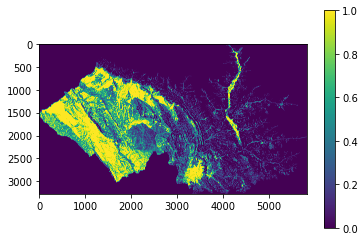

In [11]:
import os
import subprocess
import matplotlib.pyplot as plt

#os.system (cmd)
slp1=gdal.Open("/content/slope_polygon_shp_files/A1003000_shpFile/SmallerFileB1.tif")
slp1Array= slp1.GetRasterBand(1).ReadAsArray()
plt.figure()
plt.imshow(slp1Array)
plt.colorbar()
plt.show()

In [2]:
import os
import subprocess
from osgeo import gdal
#####################important import libraries
CLIPPED_ELEVATIONS = "/content/elev_correct/"
elev = [1003000, 30005000, 50007000]
save_dir = "/content/slope_polygon_shp_files/"
!mkdir -p {save_dir}
for j, elevations in enumerate(elev):
  in_image = "/content/Reclass_Slop21.tif" #enter path to SLOPE-MAP
  print(in_image)
  ################################CUTTING SLOPE-MAP BY ELEVATION
  !gdalwarp \
    -ot Float32 \
    -cutline {CLIPPED_ELEVATIONS}E{elev[j]}.shp  -crop_to_cutline \
    {in_image} \
    {save_dir}result_"{elev[j]}".tif
  ################################CUTTING SLOPE-MAP BY ELEVATION
  dir_to_store_slope_shapeFiles = str(save_dir)+"A"+str(elev[j])+"_shpFile/"
  !mkdir -p {dir_to_store_slope_shapeFiles}

  ################################RASTERIZING TO DIFFERENT CLASSES
  INPUT_SLOPE_IN_IMAGE = str(save_dir)+"result_"+str(elev[j])+".tif"
  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB1.tif \
    --NoDataValue=0 \
    --calc="(A<=1)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB1.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B1.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB2.tif \
    --NoDataValue=0 \
    --calc="(A>1)*(A<=2)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB2.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B2.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB3.tif \
    --NoDataValue=0 \
    --calc="(A>2)*(A<=3)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB3.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B3.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB4.tif \
    --NoDataValue=0 \
    --calc="(A>3)*(A<=4)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB4.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B4.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB5.tif \
    --NoDataValue=0 \
    --calc="(A>4)*(A<=5)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB5.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B5.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB6.tif \
    --NoDataValue=0 \
    --calc="(A>5)*(A<=6)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB6.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B6.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB7.tif \
    --NoDataValue=0 \
    --calc="(A>6)*(A<=7)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB7.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B7.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB8.tif \
    --NoDataValue=0 \
    --calc="(A>7)*(A<=8)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB8.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B8.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {INPUT_SLOPE_IN_IMAGE} \
    --outfile={dir_to_store_slope_shapeFiles}SmallerFileB9.tif \
    --NoDataValue=0 \
    --calc="(A>8)*(A<=9)*1"
  !gdal_polygonize.py {dir_to_store_slope_shapeFiles}SmallerFileB9.tif -f "ESRI Shapefile" {dir_to_store_slope_shapeFiles}result_B9.shp OUTPUT DN  #✅

/content/Reclass_Slop21.tif
Creating output file that is 5840P x 3283L.
Processing input file /content/Reclass_Slop21.tif.
Using internal nodata values (e.g. 2.14748e+09) for image /content/Reclass_Slop21.tif.
Copying nodata values from source /content/Reclass_Slop21.tif to destination /content/slope_polygon_shp_files/result_1003000.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/slope_polygon_shp_files/A1003000_shpFile/result_B1.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/slope_polygon_shp_files/A1003000_shpFile/result_B2.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
Creating output /content/slope_polygon_shp_files/A10030

In [ ]:
#✅Separate_by_10_slope_each_elevations_THEN_polygonize_each_vectors

CLIPPED_ELEVATIONS = "/content/elevations_aspects/"
elev = [1003000, 30005000, 50007000]
aspects = [0, 45, 90, 135, 180, 225, 270, 315]
temp_dir = "/content/elevations_aspects/"
!mkdir -p "/content/slope_polygon_shp/"
for j, elevations in enumerate(elev):
  in_image = str(CLIPPED_ELEVATIONS)+"result_"+str(elev[j])+".tif"
  print(in_image)
  dir_to_store = "/content/slope_polygon_shp/A"+str(elev[j])+"_shpFile/"
  !mkdir -p {dir_to_store}

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB1.tif \
    --NoDataValue=0 \
    --calc="(A<=1)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB1.tif -f "ESRI Shapefile" {dir_to_store}result_B1.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB2.tif \
    --NoDataValue=0 \
    --calc="(A>1)*(A<=2)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB2.tif -f "ESRI Shapefile" {dir_to_store}result_B2.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB3.tif \
    --NoDataValue=0 \
    --calc="(A>2)*(A<=3)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB3.tif -f "ESRI Shapefile" {dir_to_store}result_B3.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB4.tif \
    --NoDataValue=0 \
    --calc="(A>3)*(A<=4)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB4.tif -f "ESRI Shapefile" {dir_to_store}result_B4.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB5.tif \
    --NoDataValue=0 \
    --calc="(A>4)*(A<=5)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB5.tif -f "ESRI Shapefile" {dir_to_store}result_B5.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB6.tif \
    --NoDataValue=0 \
    --calc="(A>5)*(A<=6)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB6.tif -f "ESRI Shapefile" {dir_to_store}result_B6.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB7.tif \
    --NoDataValue=0 \
    --calc="(A>6)*(A<=7)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB7.tif -f "ESRI Shapefile" {dir_to_store}result_B7.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB8.tif \
    --NoDataValue=0 \
    --calc="(A>7)*(A<=8)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB8.tif -f "ESRI Shapefile" {dir_to_store}result_B8.shp OUTPUT DN  #✅

  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {in_image} \
    --outfile={dir_to_store}SmallerFileB9.tif \
    --NoDataValue=0 \
    --calc="(A>8)*(A<=9)*1"
  !gdal_polygonize.py {dir_to_store}SmallerFileB9.tif -f "ESRI Shapefile" {dir_to_store}result_B9.shp OUTPUT DN  #✅
